# Interpretability pipeline development

We sketch and explore here the design of a pipeline to capture and analyze xAI in NCO.

In [1]:
import os
from pathlib import Path
from typing import List
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joypy

import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader
from captum.attr import IntegratedGradients, DeepLift

import logomaker

import NegativeClassOptimization.config as config
import NegativeClassOptimization.utils as utils
import NegativeClassOptimization.preprocessing as preprocessing
from NegativeClassOptimization import ml
from NegativeClassOptimization import datasets, pipelines, visualisations

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
# TODO

# # Load from mlflow
# # Add ratios! of pos/neg
# # Add open set examples?

experiment_id = "11"
# run_name = "test"
run_id = "73a53fc4c0c74e7eababe4f1737cea0b"

# api = utils.MlflowAPI()
# r = api.mlflow_request(experiment_id, run_name)
# df = api.build_mlflow_results_df()
# df.head()

# # import requests

# # requests.get(
# #     "http://10.40.3.22:5000/api/2.0/mlflow/artifacts/list",
# #     json={
# #         "run_id": "73a53fc4c0c74e7eababe4f1737cea0b",
# #     },
# #     ).json()
# # # ftp_url = "ftp://eugen:33bY@U&ld&We@10.40.3.22/artifacts_store/11/73a53fc4c0c74e7eababe4f1737cea0b/artifacts/dataset/train_dataset.tsv/c35495f4_train_dataset.tsv"

# # # from urllib import request
# # # request.urlretrieve(ftp_url, filename=str("test.tsv"))

df_train_path = "../data/nco_mlflow_runs/ftp/artifacts_store/11/73a53fc4c0c74e7eababe4f1737cea0b/artifacts/dataset/train_dataset.tsv/c35495f4_train_dataset.tsv"
df_test_path = "../data/nco_mlflow_runs/ftp/artifacts_store/11/73a53fc4c0c74e7eababe4f1737cea0b/artifacts/dataset/test_dataset.tsv/c35495f4_test_dataset.tsv"
model_path = "../data/nco_mlflow_runs/ftp/artifacts_store/11/73a53fc4c0c74e7eababe4f1737cea0b/artifacts/models/trained_model"

1. Define and preprocess relevant pipeline inputs

In [3]:
ag_pos = "3VRL"
ag_neg = "1NSN"
df_para = utils.load_paratopes()

df = utils.load_global_dataframe()
df_train = pd.read_csv(df_train_path, sep="\t")
df_test = pd.read_csv(df_test_path, sep="\t")
model = torch.load(Path(model_path) / "data/model.pth")

attributors = [
    # ml.Attributor(
    #     model, 
    #     type="integrated_gradients", 
    #     baseline_type="zero", 
    #     compute_on="logits"
    #     ),
    # ml.Attributor(model,
    #     type="integrated_gradients", 
    #     baseline_type="shuffle",
    #     compute_on="logits"
    #     ),
    ml.Attributor(model,
        type="deep_lift", 
        baseline_type="zero",
        compute_on="logits",
        multiply_by_inputs=True,
        ),
    ml.Attributor(model,
        type="deep_lift", 
        baseline_type="zero",
        compute_on="logits",
        multiply_by_inputs=False,
        ),
    ml.Attributor(model,
        type="deep_lift", 
        baseline_type="shuffle",
        compute_on="logits",
        multiply_by_inputs=True,
        ),
    ml.Attributor(model,
        type="deep_lift", 
        baseline_type="shuffle",
        compute_on="logits",
        multiply_by_inputs=False,
        ),
    # ml.Attributor(model, type="deep_lift", baseline_type="zero", compute_on="logits"),
    # ml.Attributor(model, type="deep_lift", baseline_type="shuffle", compute_on="logits"),
]

In [4]:
df_train.head()

,Slide,binds_a_pos_ag,Slide_farmhash_mod_32768,Slide_onehot,X,y
0,AAELFWYFDVW,1,3177,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1
1,AAGYFFYFDVW,1,1605,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1
2,AALLPIRPDGY,0,736,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0
3,AASFGWDVGYF,0,2363,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0
4,ADDYDLGVFPF,0,2068,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,0


In [5]:
N = 100
res = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for row in df_train.sample(N).iterrows():
        slide = row[1]["Slide"]
        binds_a_pos_ag = row[1]["binds_a_pos_ag"]

        # Model predictions and basic parameters
        is_slide_in_train = slide in df_train["Slide"]
        enc = torch.tensor(preprocessing.onehot_encode(slide)).float().reshape((1, -1))
        expits, logits = model.forward(enc, return_logits=True)
        y_pred = expits.round()
        y_true = binds_a_pos_ag
        is_pred_correct = bool((y_pred == y_true)[0][0])
        # print(f"{y_pred=} ? {y_true=} => {is_pred_correct=}")

        # Attributions
        res_attr = {}
        for attributor in attributors:
            attributions, baseline = attributor.attribute(enc, return_baseline=True)
            baseline_expits, baseline_logits = model.forward(baseline, return_logits=True)
            res_attr[attributor.name] = {
                "attributions": attributions,
                "baseline": baseline,
                "baseline_logits": baseline_logits,
                "baseline_expits": baseline_expits,
            }

        # Record results
        res[slide] = {
            "enc": enc,
            "logits": logits,
            "expits": expits,
            "y_pred": y_pred,
            "y_true": y_true,
            "is_pred_correct": is_pred_correct,
            "attributions": res_attr,
        }


# Transform results into a dataframe
df = pd.DataFrame.from_dict(res, orient="index")
df = df.sort_values("logits", ascending=False)
df.reset_index(inplace=True)
df.rename(columns={"index": "slide"}, inplace=True)

df["logits"] = df["logits"].astype(float)
df["expits"] = df["expits"].astype(float)
df["y_pred"] = df["y_pred"].astype(int)

df.head()

,slide,enc,logits,expits,y_pred,y_true,is_pred_correct,attributions
0,CTRCGLLLTYF,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",16.217556,1.000000,1,1,True,{'deep_lift__logits__zero__multiplyTrue': {'at...
1,CARVGWLLVYF,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",15.994102,1.000000,1,1,True,{'deep_lift__logits__zero__multiplyTrue': {'at...
2,WRELGWLLRFF,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",15.111689,1.000000,1,1,True,{'deep_lift__logits__zero__multiplyTrue': {'at...
3,CARWALLLRAM,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",13.313177,0.999998,1,1,True,{'deep_lift__logits__zero__multiplyTrue': {'at...
4,FITTVVVFAYW,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",12.558086,0.999997,1,1,True,{'deep_lift__logits__zero__multiplyTrue': {'at...


In [6]:
def filter_res_for_selected_attributor(df: pd.DataFrame, attributor_sel: str):
    """Filter df for selected attributor.
    Returns:
        - df_sel: df with selected attributor (Num_slides x #cols(df))
        - df_attr: df with attributions per slide (Num_slides x 220)
    """
    records = []
    for row in df.iterrows():
        s = row[1]
        attr_data = s["attributions"][attributor_sel]
        new_row_dict = {
            **dict(s),
            **attr_data,
        }
        records.append(new_row_dict)

    df_sel = pd.DataFrame.from_records(records)
    df_sel["baseline_logits"] = df_sel["baseline_logits"].astype(float)
    df_sel["baseline_expits"] = df_sel["baseline_expits"].astype(float)
    # df_attr = pd.DataFrame(np.concatenate(df_sel["attributions"].map(lambda x: x.detach().numpy()), axis=0))
    
    return df_sel  #, df_attr


def get_df_sel(attributor_sel, df, df_para):
    """Get df_sel for selected attributor."""
    df_sel = filter_res_for_selected_attributor(df, attributor_sel)
    df_sel["Antigen"] = np.where(df_sel["y_true"] == 1, ag_pos, ag_neg)
    df_sel = pd.merge(df_sel, df_para, how="left", left_on=("slide", "Antigen"), right_on=("Slide", "Antigen"))
    return df_sel

## Case studies

For each case, we draw logos:
1. Sequence logo
2. Paratope logo
3. Deeplift with `multiply_by_inputs`
4. Deeplift without `multiply_by_inputs`

We examine 2 slides per each case:
1. Strong positive prediction
2. Strong negative prediction
3. Prediction close to 0

In [7]:
attributor_sel_1 = attributors[-1].name  # without multiply_by_inputs
attributor_sel_2 = attributors[-2].name  # with multiply_by_inputs

# Create df_sel per attributor
df_sel_1 = get_df_sel(attributor_sel_1, df, df_para)
df_sel_2 = get_df_sel(attributor_sel_2, df, df_para)

df_sel_1

,slide,enc,logits,expits,y_pred,y_true,is_pred_correct,attributions,baseline,baseline_logits,baseline_expits,Antigen,Slide,Label,hotspot_ID,agregatesAGEpitope,agregatesABParatope
0,CTRCGLLLTYF,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",16.217556,9.999999e-01,1,1,True,"[[tensor(-0.8572), tensor(1.3659), tensor(-6.4...","[[tensor(0.), tensor(0.1610), tensor(0.), tens...",-1.189215,0.233399,3VRL,CTRCGLLLTYF,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C3K1--L1--A1L3G1P2--A1T1,C2T1--C2G1L3L3L3T1Y2F4*
1,CARVGWLLVYF,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",15.994102,9.999999e-01,1,1,True,"[[tensor(-0.8652), tensor(1.3776), tensor(-6.5...","[[tensor(0.0890), tensor(0.0950), tensor(0.), ...",0.644852,0.655850,3VRL,CARVGWLLVYF,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C3K1--L1--A1L3G1P2--A1T1,C2A1--V2G1W3L3L3V1Y2F4*
2,WRELGWLLRFF,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",15.111689,9.999998e-01,1,1,True,"[[tensor(-0.7783), tensor(1.2412), tensor(-6.0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",-2.901562,0.052076,3VRL,WRELGWLLRFF,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C3K1--L1--A1L3G1P2--A1T1,W2R1--L2G1W3L3L3R1F2F4*
3,CARWALLLRAM,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",13.313177,9.999983e-01,1,1,True,"[[tensor(-0.8739), tensor(1.2399), tensor(-6.1...","[[tensor(0.2800), tensor(0.0850), tensor(0.), ...",-2.329737,0.088690,3VRL,CARWALLLRAM,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C3K1--L1--A1L3G1P2--A1T1,C2A1--W2A1L3L3L3R1A2M4*
4,FITTVVVFAYW,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",12.558086,9.999965e-01,1,1,True,"[[tensor(-0.8652), tensor(1.3776), tensor(-6.5...","[[tensor(0.0970), tensor(0.), tensor(0.), tens...",5.941614,0.997379,3VRL,FITTVVVFAYW,3VRL_C,3VRL_C_H1,D1T2L2--V1Q1--A1--P1--C3K1--L1--A1L2G1P1--A1T1,F4I2T1--V1V3V3F3A1Y1W2*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,YDGRRLSWFAY,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",-13.125357,1.994018e-06,0,0,True,"[[tensor(-1.7696), tensor(-1.1025), tensor(-2....","[[tensor(0.0840), tensor(0.), tensor(0.0870), ...",-8.407034,0.000223,1NSN,YDGRRLSWFAY,1NSN_S,1NSN_S_H1,I1K1--I2D1--T1V1K1--P1M1T1--V1--T1--Q1--D1K1Y1...,Y4D2G1R2--L4S2W3F3A2Y2*
96,SFYYDYDFFFA,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",-13.505356,1.363634e-06,0,0,True,"[[tensor(-1.8347), tensor(-1.0054), tensor(-2....","[[tensor(0.0930), tensor(0.), tensor(0.1880), ...",-5.230907,0.005320,1NSN,SFYYDYDFFFA,1NSN_S,1NSN_S_H1,I1K1--I2D2--D1T1V1K1--P1M1T1--V1--T2--E1--H1--...,F4Y2Y4D1Y1--F3F3F2A2*
97,DLEEKFSWFAY,"[[tensor(0.), tensor(0.), tensor(1.), tensor(0...",-15.134575,2.673853e-07,0,0,True,"[[tensor(-1.7696), tensor(-1.1025), tensor(-2....","[[tensor(0.1040), tensor(0.), tensor(0.0910), ...",-9.044649,0.000118,1NSN,DLEEKFSWFAY,1NSN_S,1NSN_S_H1,I1K1--I2D1--T1V1K1--P1M1T1--V1--T1--Y1G1R3--V2...,D1L3--E2--F4S2W3F3A2Y2*
98,CARIPDGLYYY,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",-15.364370,2.124901e-07,0,0,True,"[[tensor(-1.7789), tensor(-1.0759), tensor(-2....","[[tensor(0.0890), tensor(0.0880), tensor(0.085...",-7.627531,0.000487,1NSN,CARIPDGLYYY,1NSN_S,1NSN_S_H1,I1D1--T1V1K1--M1T1--V1--T1--Q1--D1--Y1G1R4G1--...,C4A2R1I3--D2--L4Y2Y3Y3*


<AxesSubplot: xlabel='logits', ylabel='is_pred_correct'>

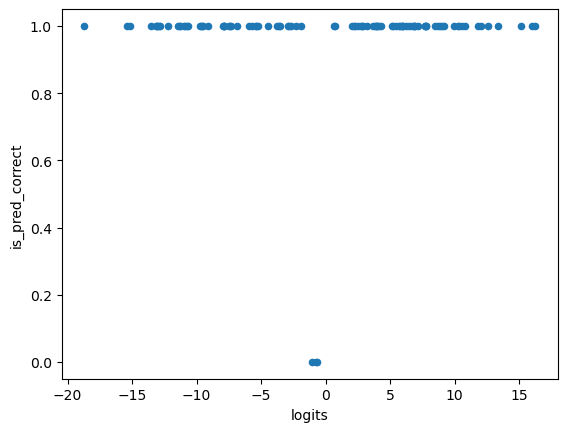

In [8]:
df_sel_1["is_pred_correct"] = df_sel_1["is_pred_correct"].astype(int)
df_sel_1.plot.scatter(x="logits", y="is_pred_correct")

In [9]:
df_sel_1.loc[df_sel_1["is_pred_correct"] == 0]

,slide,enc,logits,expits,y_pred,y_true,is_pred_correct,attributions,baseline,baseline_logits,baseline_expits,Antigen,Slide,Label,hotspot_ID,agregatesAGEpitope,agregatesABParatope
53,DLLLWLRQVYF,"[[tensor(0.), tensor(0.), tensor(1.), tensor(0...",-0.701852,0.331402,0,1,0,"[[tensor(-0.6666), tensor(1.0063), tensor(-4.6...","[[tensor(0.), tensor(0.), tensor(0.0970), tens...",-1.417787,0.195009,3VRL,DLLLWLRQVYF,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C2K1--L1--L3G1P2--A1T1,L3L3L3W1L2--Q1V1Y2F4*
54,WFLLGYAMDYW,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",-0.758567,0.318957,0,1,0,"[[tensor(-1.3914), tensor(0.8416), tensor(-5.6...","[[tensor(0.0910), tensor(0.), tensor(0.0890), ...",-2.594858,0.069470,3VRL,WFLLGYAMDYW,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C3K1--L1--A1L3G1P2--A1T1,W4F2L1L3G3Y3A1M2--Y1W2*
55,CASRLLFALFD,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",-1.088689,0.251865,0,1,0,"[[tensor(-0.4406), tensor(0.2769), tensor(-2.8...","[[tensor(0.2100), tensor(0.0890), tensor(0.079...",-3.657202,0.025155,3VRL,CASRLLFALFD,3VRL_C,3VRL_C_H1,M1--D1T2L2--V2Q1--A1--P1--C2K1--L1--L1G1P1--A1T1,C2A1--R1L3L3F3A1L2F4*


In [10]:
def plot_attribution_report_by_index(idx_1, df_sel_1, df_sel_2):
    row_sel_1_idx_1 = df_sel_1.iloc[idx_1]
    row_sel_2_idx_1 = df_sel_2.iloc[idx_1]

    print(row_sel_1_idx_1['slide'])

    fig, axs = plt.subplots(2, 2, figsize=(14, 7))
    fig.suptitle(
    f"Slide: {row_sel_1_idx_1['slide']}, y_true: {row_sel_1_idx_1['y_true']}, y_pred: {row_sel_1_idx_1['y_pred']}, "
    f"logits={row_sel_1_idx_1['logits']:0.2f}, expits={row_sel_1_idx_1['expits']:0.2f}",
    fontsize=16)

    ## Sequence
    visualisations.plot_logo(
        pd.DataFrame(
            row_sel_1_idx_1["enc"].numpy().reshape((-1, 20)), 
            columns=config.AMINOACID_ALPHABET
            ),
        ax=axs[0, 0],
    )
    axs[0, 0].set_title("Sequence")

    ## Paratope
    visualisations.plot_logo(
        pd.DataFrame(
            preprocessing.onehot_encode_deg_paratope(row_sel_1_idx_1["agregatesABParatope"]).reshape((-1, 20)), 
            columns=config.AMINOACID_ALPHABET
            ),
        ax=axs[0, 1],
    )
    axs[0, 1].set_title("Paratope with #contacts")
    
    ## Attributions: Deeplift w/ multiply by input
    visualisations.plot_logo(
        pd.DataFrame(
            row_sel_2_idx_1["attributions"].detach().numpy().reshape((-1, 20)), 
            columns=config.AMINOACID_ALPHABET
            ),
        ax=axs[1, 0],
    )
    axs[1, 0].set_title("('Global' Attributions): Deeplift with `multiply by input`")

    ## Attributions: Deeplift w/o multiply by input
    visualisations.plot_logo(
        pd.DataFrame(
            row_sel_1_idx_1["attributions"].detach().numpy().reshape((-1, 20)), 
            columns=config.AMINOACID_ALPHABET
            ),
        ax=axs[1, 1],
    )
    axs[1, 1].set_title("('Local' Attributions): Deeplift without `multiply by input`")

Slides case 1: strong positive prediction

CTRCGLLLTYF


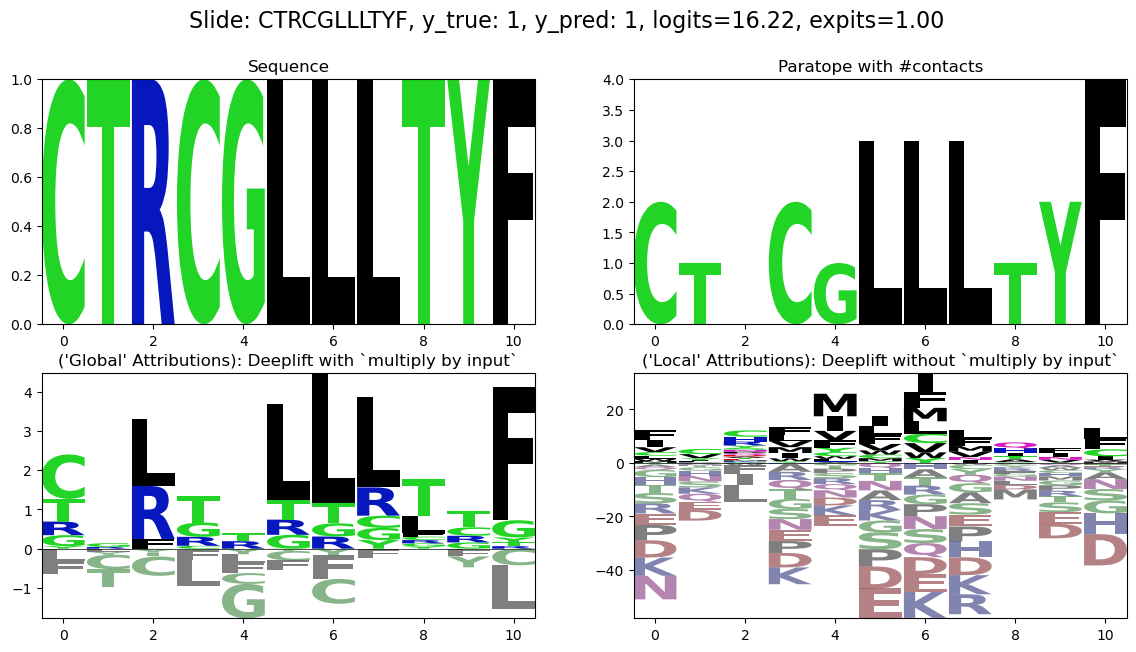

In [11]:
plot_attribution_report_by_index(0, df_sel_1, df_sel_2)

WRELGWLLRFF


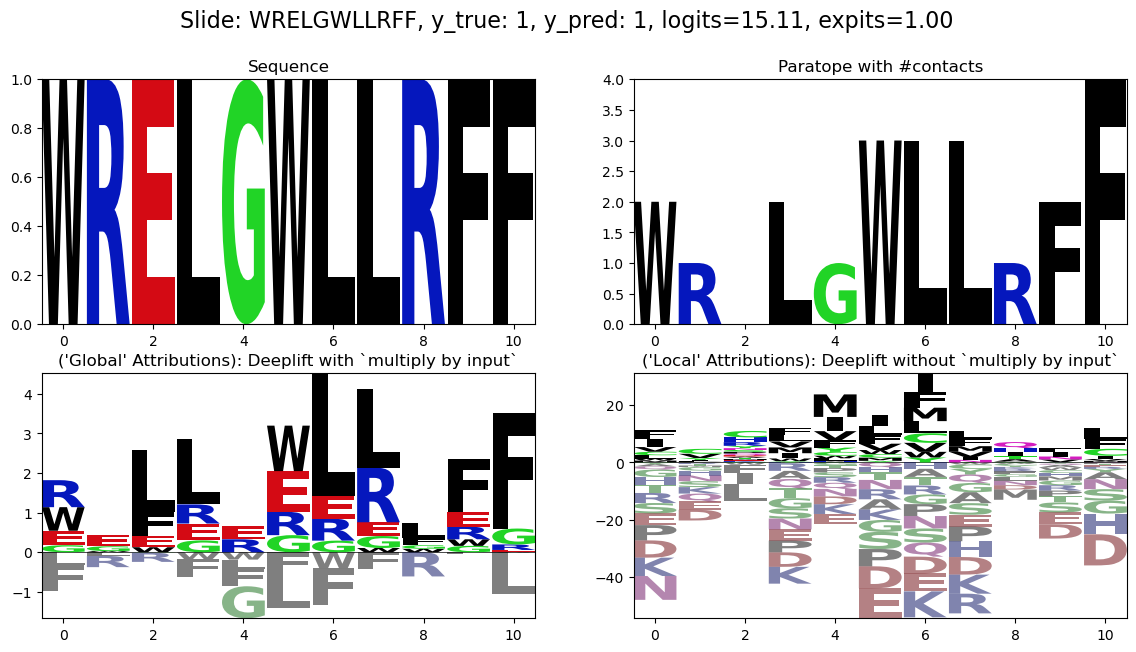

In [12]:
plot_attribution_report_by_index(2, df_sel_1, df_sel_2)

LGDLLLRVEAM


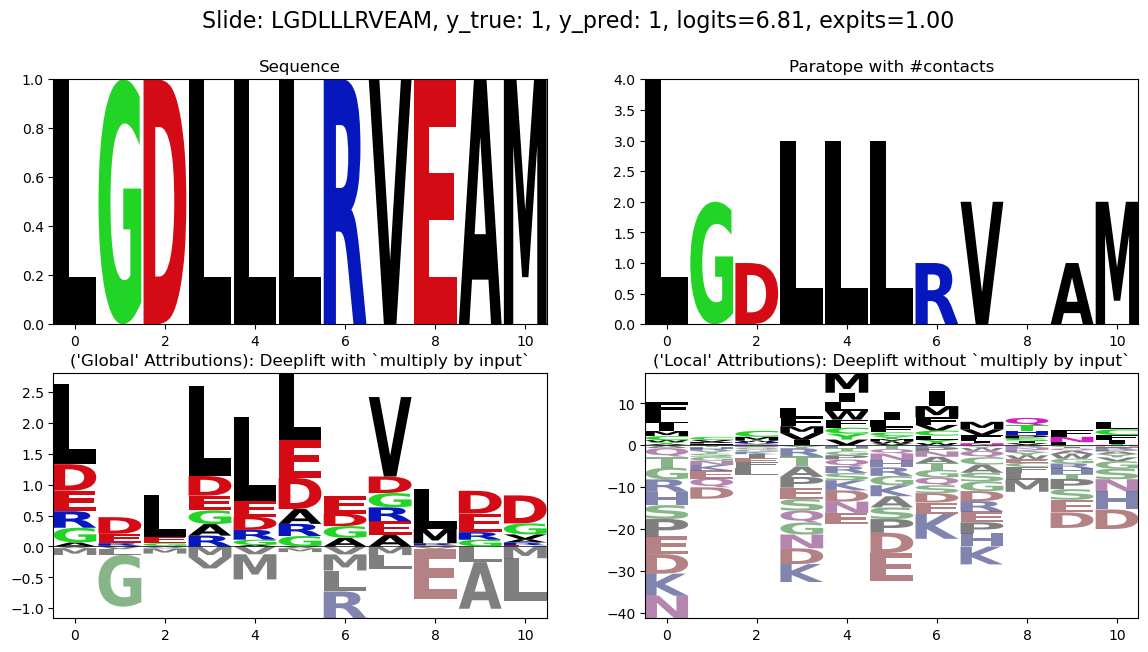

In [13]:
plot_attribution_report_by_index(24, df_sel_1, df_sel_2)

Slides case 2: unconfident, near 0 predictions

RRQLGLLFDYW


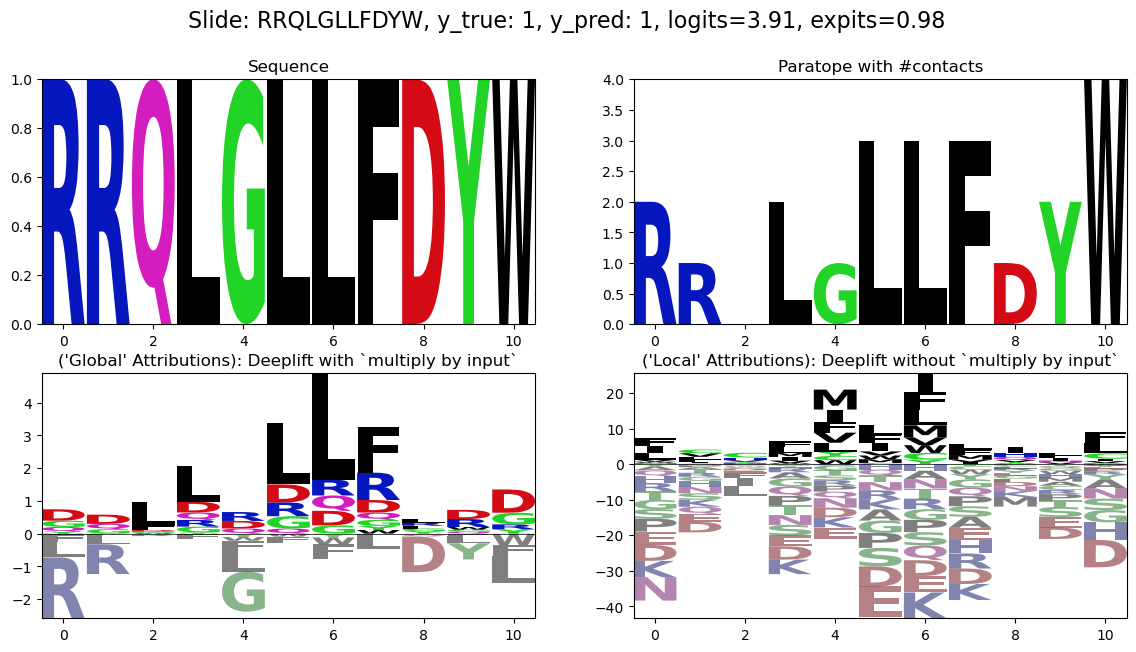

In [14]:
plot_attribution_report_by_index(40, df_sel_1, df_sel_2)
# Unconfident because saw a D at position 4, and 8?

FFDLFLSRFNY


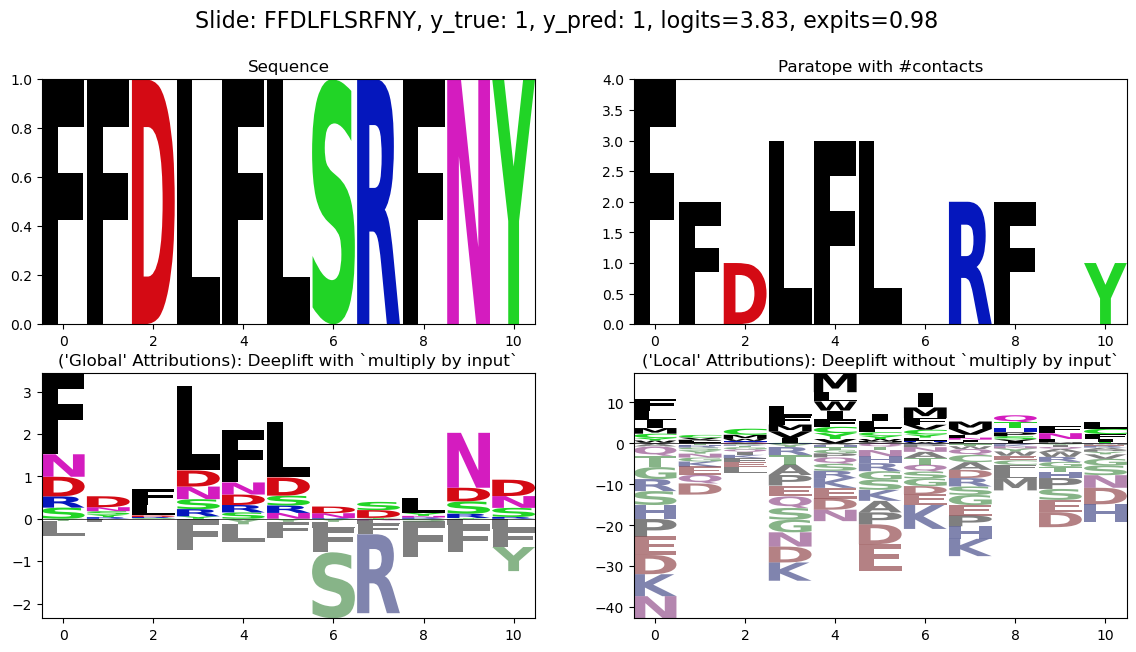

In [15]:
plot_attribution_report_by_index(41, df_sel_1, df_sel_2)

Slides case 3: confident, negative predictions

CASWELPFDYW


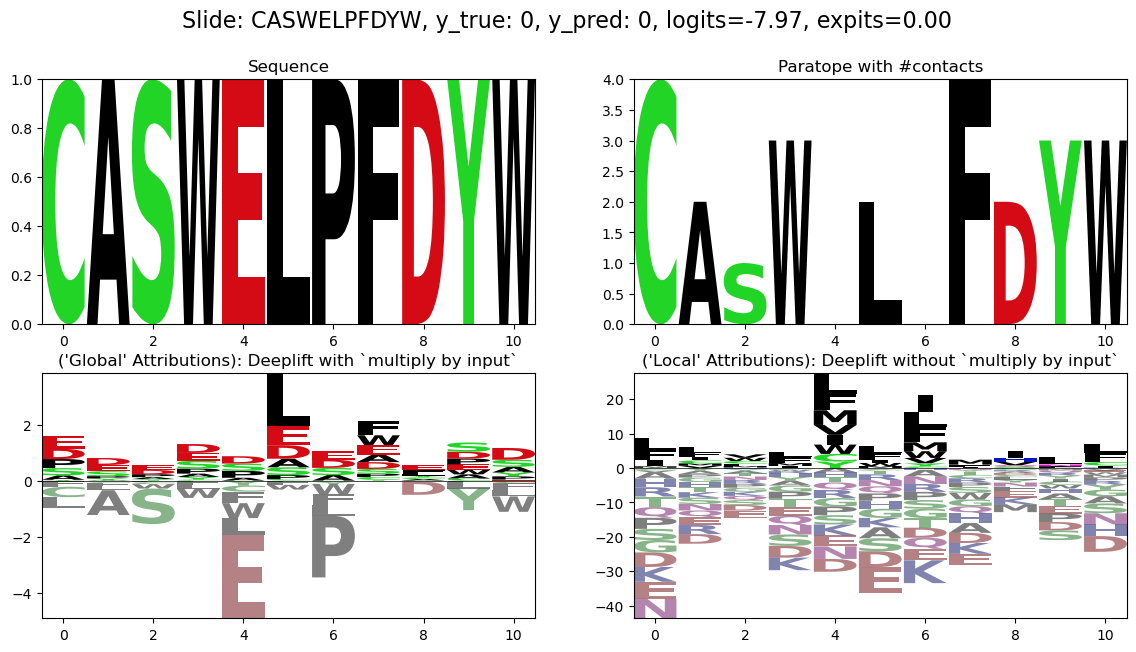

In [16]:
plot_attribution_report_by_index(77, df_sel_1, df_sel_2)

VRELGEGFAYW


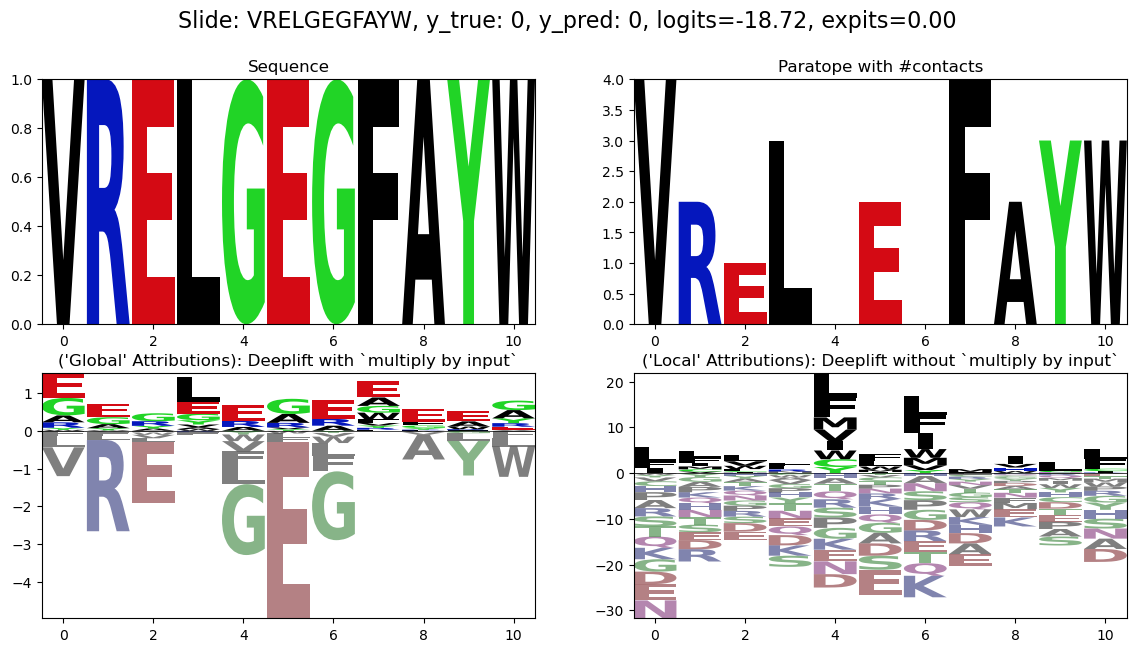

In [17]:
plot_attribution_report_by_index(99, df_sel_1, df_sel_2)

## Compute mistakes between attributions and paratopes.

In [18]:
df_sel_1

,slide,enc,logits,expits,y_pred,y_true,is_pred_correct,attributions,baseline,baseline_logits,baseline_expits,Antigen,Slide,Label,hotspot_ID,agregatesAGEpitope,agregatesABParatope
0,CTRCGLLLTYF,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",16.217556,9.999999e-01,1,1,1,"[[tensor(-0.8572), tensor(1.3659), tensor(-6.4...","[[tensor(0.), tensor(0.1610), tensor(0.), tens...",-1.189215,0.233399,3VRL,CTRCGLLLTYF,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C3K1--L1--A1L3G1P2--A1T1,C2T1--C2G1L3L3L3T1Y2F4*
1,CARVGWLLVYF,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",15.994102,9.999999e-01,1,1,1,"[[tensor(-0.8652), tensor(1.3776), tensor(-6.5...","[[tensor(0.0890), tensor(0.0950), tensor(0.), ...",0.644852,0.655850,3VRL,CARVGWLLVYF,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C3K1--L1--A1L3G1P2--A1T1,C2A1--V2G1W3L3L3V1Y2F4*
2,WRELGWLLRFF,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",15.111689,9.999998e-01,1,1,1,"[[tensor(-0.7783), tensor(1.2412), tensor(-6.0...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",-2.901562,0.052076,3VRL,WRELGWLLRFF,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C3K1--L1--A1L3G1P2--A1T1,W2R1--L2G1W3L3L3R1F2F4*
3,CARWALLLRAM,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",13.313177,9.999983e-01,1,1,1,"[[tensor(-0.8739), tensor(1.2399), tensor(-6.1...","[[tensor(0.2800), tensor(0.0850), tensor(0.), ...",-2.329737,0.088690,3VRL,CARWALLLRAM,3VRL_C,3VRL_C_H1,D1T1L2--V1Q1--A1--P1--C3K1--L1--A1L3G1P2--A1T1,C2A1--W2A1L3L3L3R1A2M4*
4,FITTVVVFAYW,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",12.558086,9.999965e-01,1,1,1,"[[tensor(-0.8652), tensor(1.3776), tensor(-6.5...","[[tensor(0.0970), tensor(0.), tensor(0.), tens...",5.941614,0.997379,3VRL,FITTVVVFAYW,3VRL_C,3VRL_C_H1,D1T2L2--V1Q1--A1--P1--C3K1--L1--A1L2G1P1--A1T1,F4I2T1--V1V3V3F3A1Y1W2*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,YDGRRLSWFAY,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",-13.125357,1.994018e-06,0,0,1,"[[tensor(-1.7696), tensor(-1.1025), tensor(-2....","[[tensor(0.0840), tensor(0.), tensor(0.0870), ...",-8.407034,0.000223,1NSN,YDGRRLSWFAY,1NSN_S,1NSN_S_H1,I1K1--I2D1--T1V1K1--P1M1T1--V1--T1--Q1--D1K1Y1...,Y4D2G1R2--L4S2W3F3A2Y2*
96,SFYYDYDFFFA,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0...",-13.505356,1.363634e-06,0,0,1,"[[tensor(-1.8347), tensor(-1.0054), tensor(-2....","[[tensor(0.0930), tensor(0.), tensor(0.1880), ...",-5.230907,0.005320,1NSN,SFYYDYDFFFA,1NSN_S,1NSN_S_H1,I1K1--I2D2--D1T1V1K1--P1M1T1--V1--T2--E1--H1--...,F4Y2Y4D1Y1--F3F3F2A2*
97,DLEEKFSWFAY,"[[tensor(0.), tensor(0.), tensor(1.), tensor(0...",-15.134575,2.673853e-07,0,0,1,"[[tensor(-1.7696), tensor(-1.1025), tensor(-2....","[[tensor(0.1040), tensor(0.), tensor(0.0910), ...",-9.044649,0.000118,1NSN,DLEEKFSWFAY,1NSN_S,1NSN_S_H1,I1K1--I2D1--T1V1K1--P1M1T1--V1--T1--Y1G1R3--V2...,D1L3--E2--F4S2W3F3A2Y2*
98,CARIPDGLYYY,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...",-15.364370,2.124901e-07,0,0,1,"[[tensor(-1.7789), tensor(-1.0759), tensor(-2....","[[tensor(0.0890), tensor(0.0880), tensor(0.085...",-7.627531,0.000487,1NSN,CARIPDGLYYY,1NSN_S,1NSN_S_H1,I1D1--T1V1K1--M1T1--V1--T1--Q1--D1--Y1G1R4G1--...,C4A2R1I3--D2--L4Y2Y3Y3*


In [104]:
from collections import OrderedDict
from scipy.stats import rankdata


def get_paratope_ranks(y_true_class: int, df_sel):
    paratope_ranks = OrderedDict()
    for i, row in df_sel_2.iterrows():
        if row["y_true"] != y_true_class:
            continue

        slide = row["slide"]
        attr = row["attributions"].detach().numpy().reshape((11, 20))
    
        try:
            paratope = preprocessing.onehot_encode_nodeg_paratope(
            preprocessing.get_no_degree_paratope(
                row["agregatesABParatope"]
            )
        ).reshape((11, 20))
        except ValueError:
            continue

        ranks = rankdata(-attr, axis=1, method="ordinal")
        paratope_ranks_arr = (ranks * paratope).sum(axis=1)
        paratope_ranks_arr = np.where(paratope_ranks_arr == 0, -10, paratope_ranks_arr)
        paratope_ranks[slide] = paratope_ranks_arr
    return paratope_ranks

paratope_ranks_1 = get_paratope_ranks(1, df_sel_2)

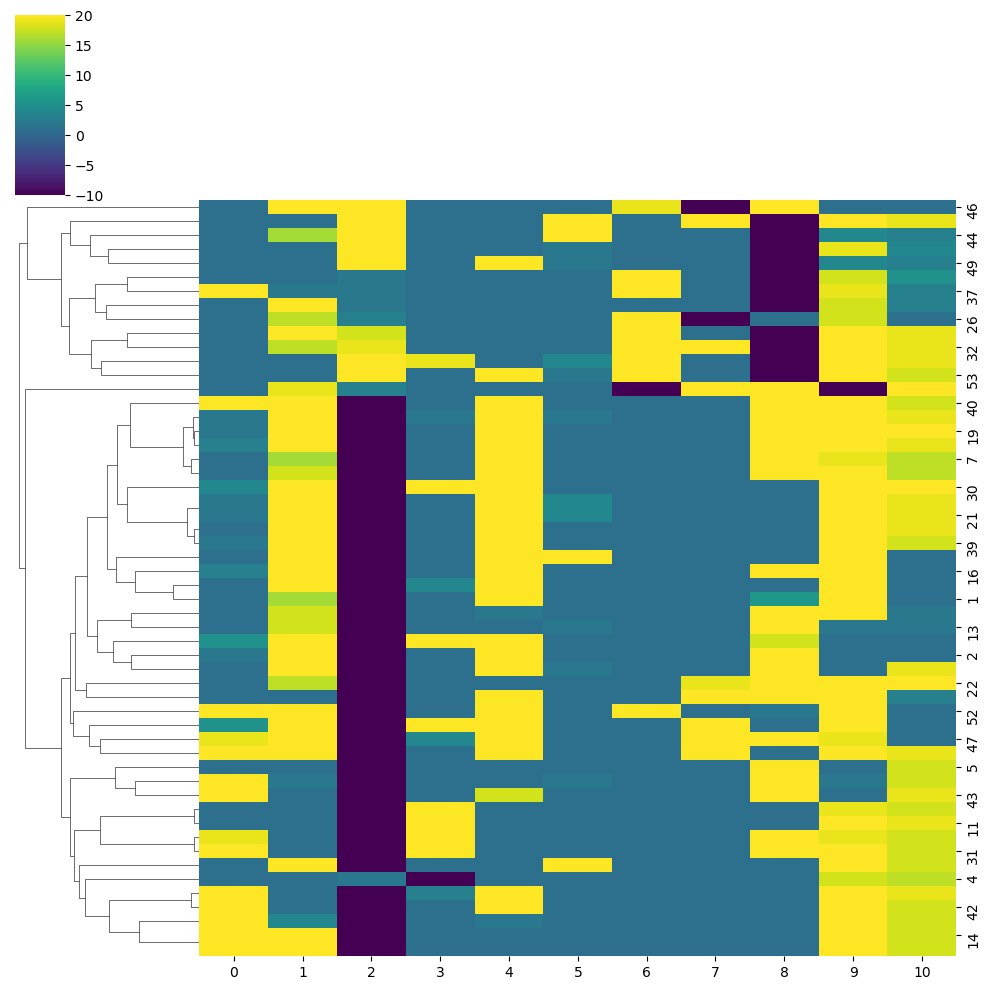

In [105]:
df_paratope_ranks_1 = pd.DataFrame(paratope_ranks_1.values())

sns.clustermap(df_paratope_ranks_1, row_cluster=True, col_cluster=False, cmap="viridis")

# sns.scatterplot(
#     data=df_paratope_ranks.melt(var_name="index", value_name="attribution_rank"),
#     x="index",
#     y="attribution_rank",
#     )

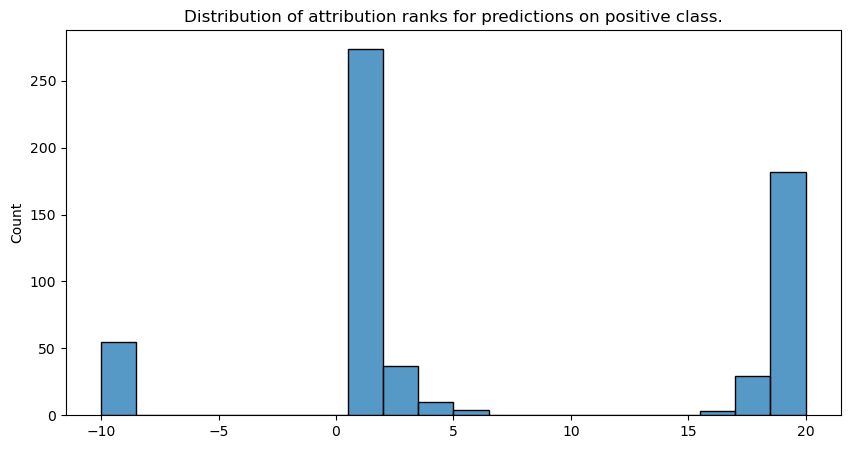

In [106]:
def plot_attr_ranks_dist(df_paratope_ranks):
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(df_paratope_ranks.values.reshape(-1), bins=20, ax=ax)
    ax.set_title("Distribution of attribution ranks for predictions on positive class.")

plot_attr_ranks_dist(df_paratope_ranks_1)

<AxesSubplot: ylabel='Frequency'>

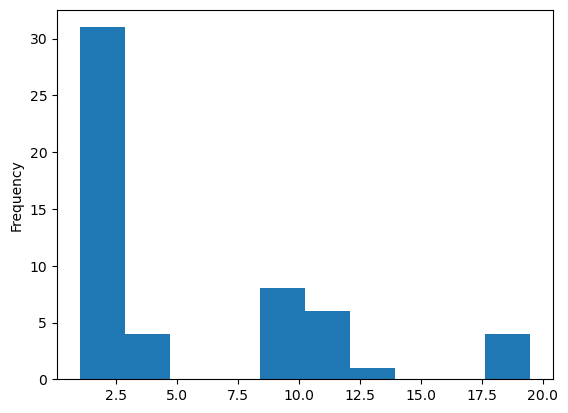

In [117]:
df_paratope_ranks_1.replace(-10, np.nan).median(axis=1, skipna=True).plot.hist()

<AxesSubplot: >

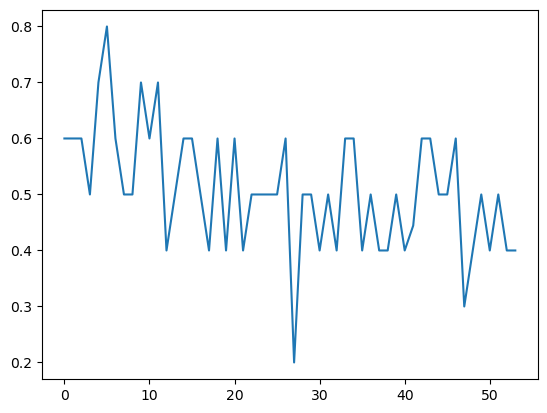

In [122]:
((df_paratope_ranks_1 == 1).sum(axis=1) / (df_paratope_ranks_1 != -10).sum(axis=1)).plot()

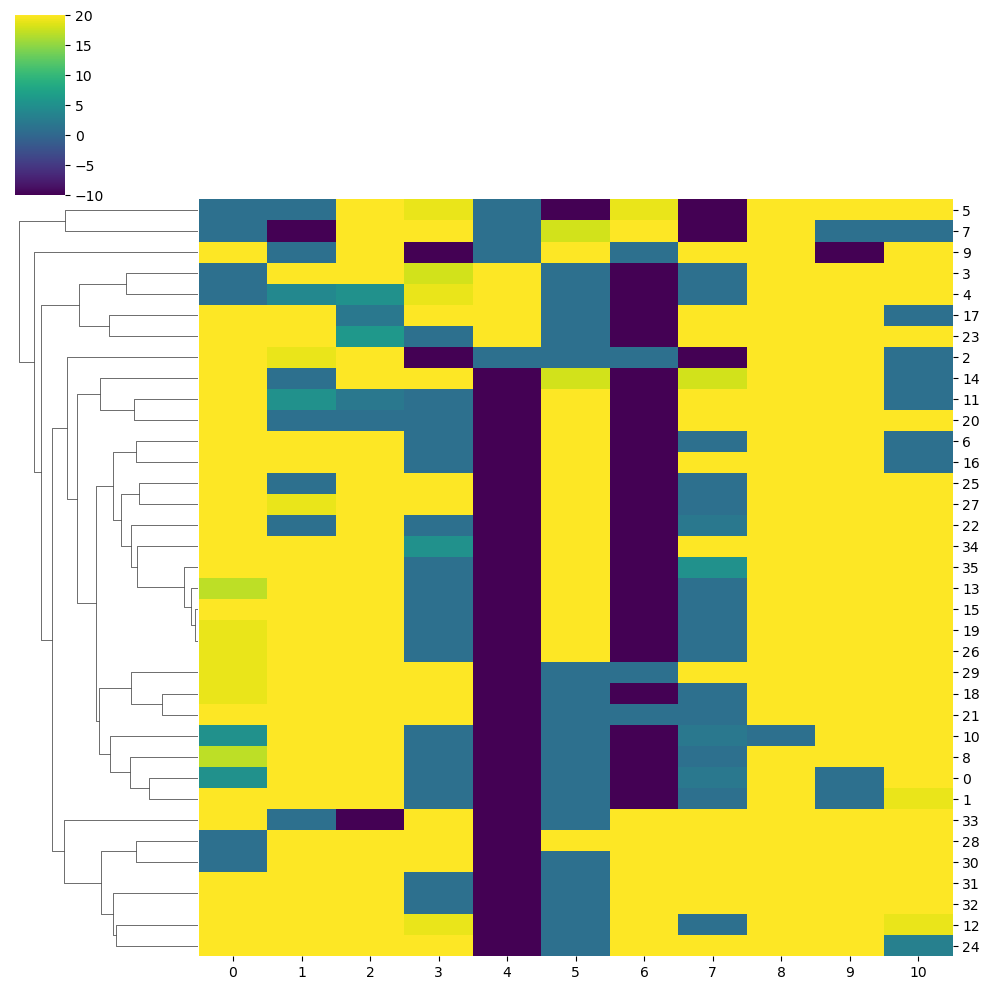

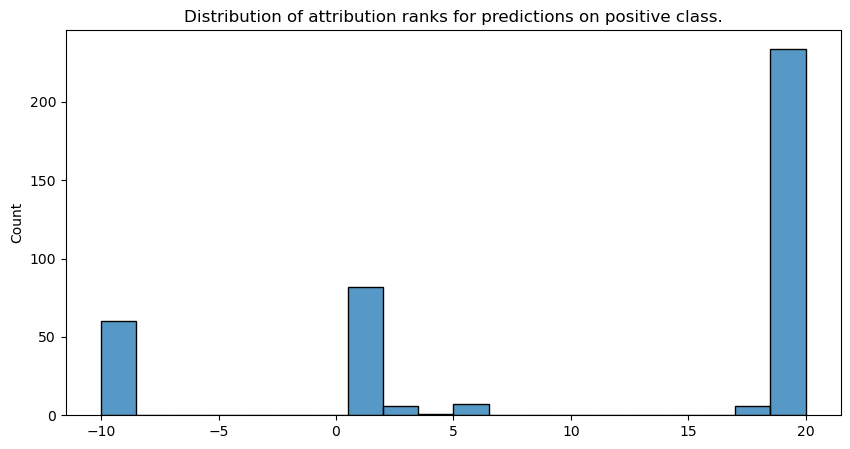

In [109]:
paratope_ranks_0 = get_paratope_ranks(0, df_sel_2)
df_paratope_ranks_0 = pd.DataFrame(paratope_ranks_0.values())
sns.clustermap(df_paratope_ranks_0, row_cluster=True, col_cluster=False, cmap="viridis")
plot_attr_ranks_dist(df_paratope_ranks_0)

<AxesSubplot: ylabel='Frequency'>

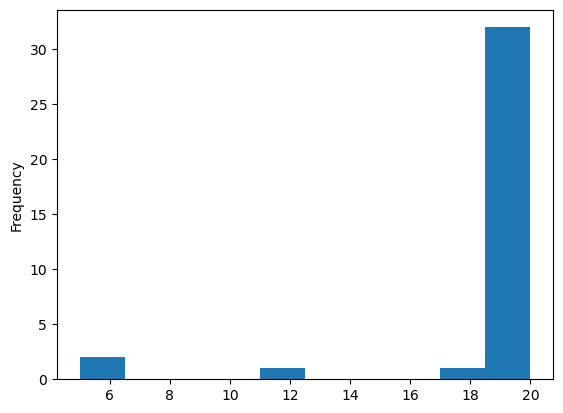

In [118]:
df_paratope_ranks_0.replace(-10, np.nan).median(axis=1, skipna=True).plot.hist()

<AxesSubplot: >

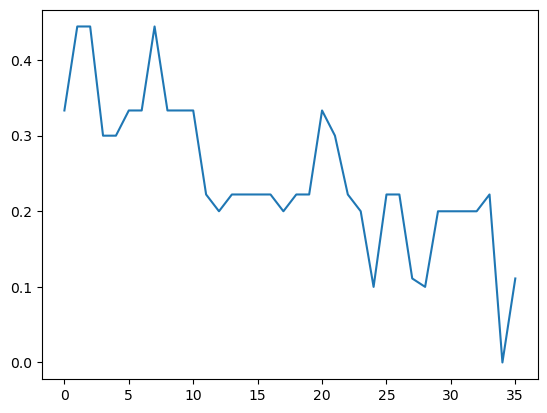

In [123]:
((df_paratope_ranks_0 == 1).sum(axis=1) / (df_paratope_ranks_0 != -10).sum(axis=1)).plot()